# code in progress. see demo.ipynb for working version 

In [1]:
## Imports

# Native packages
from math import radians, degrees, sin, cos, asin, acos, sqrt
import datetime
import sys
import os


# Third-party packages for data manipulation
import numpy as np
import pandas as pd
import xarray as xr

# Other third-party packages
from tqdm import tqdm
from time import sleep
import netCDF4 as nc4

# Third-party packages for data interpolation
from scipy import interpolate
from scipy.interpolate import griddata
from xgcm import Grid

# Third-party packages for data visualizations
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d

# osse tools package
# del sys.modules['osse_tools']  # uncomment if troubleshooting osse_tools
from osse_tools import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp

In [2]:
# --------------------------------------------------------------------
# USER INPUTS:
# --------------------------------------------------------------------

# specify region from this list:
# WesternMed  ROAM_MIZ  NewCaledonia  NWPacific  BassStrait  RockallTrough  ACC_SMST
# MarmaraSea  LabradorSea  CapeBasin
RegionName = 'ACC_SMST' 

# specify date range as start date & number of days.
start_date = datetime.date(2012,1,1)
ndays = 31
ndays = 2
# ndays = 10

# directory where data files are stored
# datadir = './data/' # default is ./data
datadir = '/data1/adac/mitgcm/netcdf/' + RegionName + '/'
outputdir = '/data1/adac/osse_output/' + RegionName + '/'
argodir = '/data1/argo/gridded/' # store argo climatology here

# optional details for sampling (if not specified, reasonable defaults will be used)
sampling_details = {
    'SAMPLING_STRATEGY' : 'sim_uctd', # options: sim_glider, sim_uctd or trajectory_file.add: mooring, ASV
#     'SAMPLING_STRATEGY' : 'sim_mooring', # options: sim_glider, sim_uctd or trajectory_file.add: mooring, ASV
    'PATTERN' : 'lawnmower', # back-forth or lawnmower 
    'zrange' : [-1, -1000],  # depth range of T/S profiles (down is negative). * add U/V range? *
    #'hspeed' : 0.25,  # platform horizontal speed in m/s
    #'vspeed' : 0.1, # platform vertical (profile) speed in m/s 
    #'trajectory_file' : None, # if SAMPLING_STRATEGY = 'trajectory_file', specify trajectory file
    #'AT_END' : 'repeat' # behaviour at and of trajectory: 'reverse', 'repeat' or 'terminate'. (could also 'restart'?)
}

# ---- generate name of file to save outputs in ---- TO DO STILL ---
# print(np.datetime_data(start_date) + np.timedelta64(ndays, 'D'))
# filename_out = [f'osse_{RegionName}_{start_date}_to_{start_date + np.timedelta64(ndays, 'd')}']
# print(filename_out)
# --------------------------------------------------------------------

#### Download & load model data and derived fields

Based on [LLC4320](https://data.nas.nasa.gov/viz/vizdata/llc4320/index.html), the 1/48-degree global MITgcm simulation produced by the ECCO project. Ten regional cut-outs of the simulation are available on the [PO.DAAC](https://podaac.jpl.nasa.gov/datasetlist?ids=Processing+Levels&values=4+-+Gridded+Model+Output&search=Pre-SWOT+llc4320&view=list&provider=); the 4x4 degree regional domains are small enough to enable fairly easy downloads and processing. The data from the model were retrieved using download_llc4320.ipynb and saved locally.

In [4]:
# download files:
# download_llc4320_data(RegionName, datadir, start_date, ndays)


# *************** ERROR IN compute_derived_fields - saving files doesn't right
#
# see dout to troubleshoot
# seems to be a problem with the argo file, which has coord/dim/etc. "time" that screws everything up by overwriting the "dout" time variable with something weird
# - since we dno't evern use time, delete from argods

# del sys.modules['osse_tools']  # uncomment if troubleshooting osse_tools
from osse_tools import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp
# derive & save new files with steric height & vorticity
compute_derived_fields(RegionName, datadir, start_date, ndays)

In [3]:
# Load all model data files  
date_list = [start_date + datetime.timedelta(days=x) for x in range(ndays)]
target_files = [f'{datadir}LLC4320_pre-SWOT_{RegionName}_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
ds = xr.open_mfdataset(target_files, parallel=True)

# load the corresponding derived fields
derivedir = datadir + 'derived/'
derived_files = [f'{derivedir}LLC4320_pre-SWOT_{RegionName}_derived-fields_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
dsd = xr.open_mfdataset(derived_files)

# merge the derived and raw data
ds = ds.merge(dsd)

# Convert lon, lat and z to index i, j and k with f_x, f_y and f_z
# XC, YC and Z are the same at all times, so select a single time
X = ds.XC.isel(time=0) 
Y = ds.YC.isel(time=0)

### Create & plot sampling track

In [4]:
del sys.modules['osse_tools'] 
from osse_tools import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp

sampling_details['AT_END'] = 'repeat'
# sampling_details['AT_END'] = 'terminate'
sampling_details['AT_END'] = 'reverse'


survey_track, survey_indices, sampling_parameters = get_survey_track(ds, sampling_details)

# print specified sampling_details + any default values
sampling_parameters 

originally,  169200  points
167831.0


{'zrange': [-1, -1000.0],
 'hspeed': 5,
 'vspeed': 1,
 'AT_END': 'reverse',
 'SAMPLING_STRATEGY': 'sim_uctd',
 'PATTERN': 'lawnmower',
 'distance_total_km': 839.155}

### Visualizations

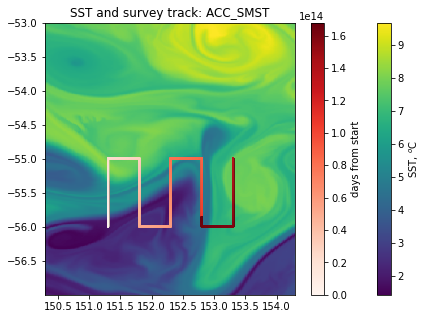

In [5]:
## Visualize track over a single model snapshot:
%matplotlib inline
plt.figure(figsize=(7,5))
ssto = plt.pcolormesh(X,Y,ds.Theta.isel(k=0, time=0).values, shading='auto')
tracko = plt.scatter(survey_track.lon, survey_track.lat, c=survey_track.time-survey_track.time[0], cmap='Reds', s=0.75)
plt.title('SST and survey track: ' + RegionName)
plt.colorbar(ssto).set_label('SST, $^o$C')
plt.colorbar(tracko).set_label('days from start')
plt.show()

(15340.0, 15342.0)

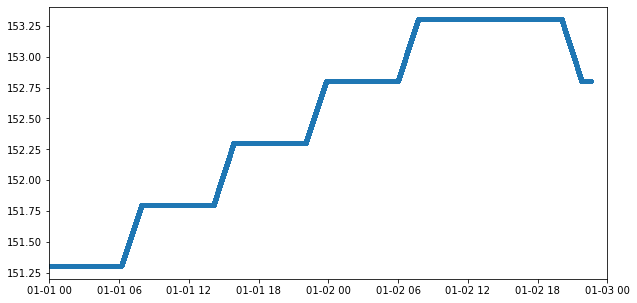

In [6]:
plt.figure(figsize=(10,5))
plt.plot(survey_track.time, survey_track.lon, marker='.')
plt.xlim([start_date + datetime.timedelta(days=0), start_date + datetime.timedelta(days=2)])

### Interpolate data with the specified sampling pattern (this is where the magic happens!)

In [54]:
del sys.modules['osse_tools'] 
from osse_tools import survey_interp, get_survey_track

subsampled_data, sgridded = survey_interp(ds, survey_track, survey_indices)


# for i in tqdm(range(100)):
#     subsampled_data, sgridded = survey_interp(ds, survey_track, survey_indices)
#     sleep(0.02)
# TO DO - for mooring / long time series, is it faster to directly interp?

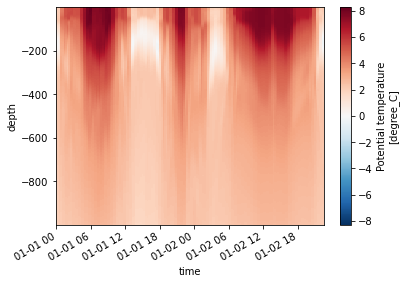

In [55]:
sgridded.Theta.plot()

### Save interpolated data

For both raw and gridded subsampled data, add attributes and save


In [56]:
# output filename base:
# --- auto generated but can be set by user ---
filename_out_base = (f'{outputdir}OSSE_{RegionName}_{sampling_parameters["SAMPLING_STRATEGY"]}_{attrs["start_date"]}_to_{attrs["end_date"]}')


# add metadata to attributes
attrs = sampling_parameters
attrs['start_date'] = start_date.strftime('%Y-%m-%d')
end_date = subsampled_data['time'].data[-1]
attrs['end_date'] = np.datetime_as_string(end_date,unit='D')
attrs['ndays'] = ndays

In [57]:
# ------ subsampled:
filename_out = filename_out_base + '_subsampled.nc'
print(f'saving to {filename_out}')
subsampled_data.attrs = attrs
netcdf_fill_value = nc4.default_fillvals['f4']
dv_encoding={'zlib':True,  # turns compression on\
            'complevel':9,     # 1 = fastest, lowest compression; 9=slowest, highest compression \
            'shuffle':True,    # shuffle filter can significantly improve compression ratios, and is on by default \
            'dtype':'float32',\
            '_FillValue':netcdf_fill_value}
# save to a new file
# subsampled_data.to_netcdf(filename_out,format='netcdf4',encoding=dv_encoding)
subsampled_data.to_netcdf(filename_out,format='netcdf4')


saving to /data1/adac/osse_output/ACC_SMST/OSSE_ACC_SMST_sim_uctd_2012-01-01_to_2012-01-02_subsampled.nc


In [59]:
# ------ gridded:
filename_out = filename_out_base + '_gridded.nc'
print(f'saving to {filename_out}')
sgridded.attrs = attrs
netcdf_fill_value = nc4.default_fillvals['f4']
dv_encoding={'zlib':True,  # turns compression on\
            'complevel':9,     # 1 = fastest, lowest compression; 9=slowest, highest compression \
            'shuffle':True,    # shuffle filter can significantly improve compression ratios, and is on by default \
            'dtype':'float32',\
            '_FillValue':netcdf_fill_value}
# save to a new file
# subsampled_data.to_netcdf(filename_out,format='netcdf4',encoding=dv_encoding)
sgridded.to_netcdf(filename_out,format='netcdf4')


saving to /data1/adac/osse_output/ACC_SMST/OSSE_ACC_SMST_sim_uctd_2012-01-01_to_2012-01-02_gridded.nc


In [44]:
start_date.strftime('%Y-%m-%d')
# attrs

'2012-01-01'

In [25]:
end_date = subsampled_data['time'].data[-1]
print(np.datetime_as_string(end_date,unit='D'))
print(end_date)

2012-01-02
2012-01-02T22:37:11.000000000


In [ ]:
# basic plot
sgridded.Theta.plot()


### Visualize interpolated data in 3D

In [ ]:
%matplotlib qt

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
fig.subplots_adjust(left=0.25, bottom=0.25)

ax.set_xlabel('longitude', fontsize=15, rotation=150)
ax.set_ylabel('latitude',fontsize=15)
ax.set_zlabel('depth', fontsize=15, rotation=60)

p = ax.scatter3D(subsampled_data.lon.data, subsampled_data.lat.data, subsampled_data.dep.data, c=subsampled_data.Theta.data, s=1)
fig.colorbar(p).set_label('Temperature ($^o$C)')
ax.set_title('Temperature interpolated to the survey track')

In [ ]:
# sgridded.oceTAUX.plot()
plt.quiver(sgridded.time.data,0,sgridded.oceTAUX.data, sgridded.oceTAUY.data)

In [ ]:
# plot to compare the two methods 
# ( not quite working )
tpl = ds['time']/24,sss[:,0,0,0]
ttt=ds['time']
# ipl = ( subsampled_data.dep.values == subsampled_data.dep.values.min() )
# plt.plot(subsampled_data.time(ipl),subsampled_data.Salt.sel(ipl).data,'-')
# plt.plot(subsampled_data.time,subsampled_data.Salt.data,'-')
plt.plot(tgr,np.transpose(dum),'-')
plt.plot(ttt[:],sss[:,0,0,0],'k--')
# plt.legend('survey_interp method','direct interpolation')

### Visualize steric height

In [ ]:
%matplotlib inline
sh_anom = sh_true.values - sh_true.values.mean()
plt.figure(figsize=(7,5))
sho = plt.scatter(survey_track.lon, survey_track.lat, c=sh_anom)
plt.title('Steric height anomaly')
plt.colorbar(sho).set_label('m')
plt.show()

### Comparison of true vs sampled steric height
Plot comparing the "true" steric height along the track and the subsampled steric height, which is computed by integrating the specific volume anomaly for each subsampled profile from its deepest sampling depth

In [ ]:
%matplotlib inline

# truth:
plt.plot(sh_true.time, sh_true.values - sh_true.values.mean())
# get index of the deepest sampling depths
i = ( subsampled_data.dep.values == subsampled_data.dep.values.min() )
plt.plot(subsampled_data.time.values[i], subsampled_data.steric_height.values[i] - subsampled_data.steric_height.values[i].mean(),'.-')
plt.title('Steric height anomaly along the survey track')
plt.legend(['truth','subsampled data'])
plt.xlabel('time, days')
plt.ylabel('steric height anom., m')

In [ ]:
# NEW CODE  BELOW

# interpolation:
subsampled_data = xr.Dataset()  

# loop & interpolate through 3d variables:
vbls3d = ['Theta','Salt','vorticity']
# vbls3d = ['Theta']
for vbl in vbls3d:
    subsampled_data[vbl]=ds[vbl].interp(survey_indices)
# # Interpolate U and V from i_g, j_g to i, j, then interpolate:
# U_c = grid.interp(ds.U, 'X', boundary='extend')
# V_c = grid.interp(ds.V, 'Y', boundary='extend')
# subsampled_data['U'] = U_c.interp(survey_indices)
# subsampled_data['V'] = V_c.interp(survey_indices)

subsampled_data['lon']=survey_track.lon
subsampled_data['lat']=survey_track.lat
subsampled_data['dep']=survey_track.dep
subsampled_data['time']=survey_track.time 

# loop & interpolate through 2d variables:
vbls2d = ['Eta', 'KPPhbl', 'PhiBot', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux', 'oceTAUX', 'oceTAUY']
vbls2d = ['Eta', 'Depth']
# create 2-d survey track by removing the depth dimension
survey_indices_2d =  survey_indices.drop_vars('k')
for vbl in vbls2d:
    subsampled_data[vbl]=ds[vbl].interp(survey_indices_2d)
# survey_indices_2d.i.plot()
# ds['KPPhbl'].interp(survey_indices_2d).plot()

# interp
# this returns a value at every timestep (points) - very high resolution
# - could subsample to the model time grid 


# plot
# plt.plot(sh_true.time, sh_true.values - sh_true.values.mean())
# plt.plot(subsampled_data.time, ssh - ssh.mean())


In [ ]:
subsampled_data = xr.Dataset() 

# loop & interpolate through 3d variables:
vbls3d = ['Theta','Salt','vorticity','steric_height']
for vbl in vbls3d:
    subsampled_data[vbl]=ds[vbl].interp(survey_indices)
# Interpolate U and V from i_g, j_g to i, j, then interpolate:
# Get u, v
grid = Grid(ds, coords={'X':{'center': 'i', 'left': 'i_g'}, 
                        'Y':{'center': 'j', 'left': 'j_g'},
                        'Z':{'center': 'k'}})
U_c = grid.interp(ds.U, 'X', boundary='extend')
V_c = grid.interp(ds.V, 'Y', boundary='extend')
subsampled_data['U'] = U_c.interp(survey_indices)
subsampled_data['V'] = V_c.interp(survey_indices)


# add lat/lon/time to dataset
subsampled_data['lon']=survey_track.lon
subsampled_data['lat']=survey_track.lat
subsampled_data['dep']=survey_track.dep
subsampled_data['time']=survey_track.time  

# loop & interpolate through 2d variables:
vbls2d = ['Eta', 'KPPhbl', 'PhiBot', 'oceFWflx', 'oceQnet', 'oceQsw', 'oceSflux']
# create 2-d survey track by removing the depth dimension
survey_indices_2d =  survey_indices.drop_vars('k')
for vbl in vbls2d:
    subsampled_data[vbl]=ds[vbl].interp(survey_indices_2d)   
# taux & tauy must be treated like U and V
oceTAUX_c = grid.interp(ds.oceTAUX, 'X', boundary='extend')
oceTAUY_c = grid.interp(ds.oceTAUY, 'Y', boundary='extend')
subsampled_data['oceTAUX'] = oceTAUX_c.interp(survey_indices_2d)
subsampled_data['oceTAUY'] = oceTAUY_c.interp(survey_indices_2d)


    

In [ ]:
ds.U

In [ ]:
plt.plot(sh_true.time, sh_true.values - sh_true.values.mean())
plt.plot(subsampled_data.time, ssh - ssh.mean())


In [ ]:
# mooring test

model_xav = ds.XC.cccc.mean(dim='i').values
model_yav = ds.YC.isel(time=0, i=0).mean(dim='j').values

xmooring = model_xav # default lat/lon is the center of the domain
ymooring = model_yav
zmooring_TS = [-1, -10, -50, -100] # depth of T/S instruments
zmooring_UV = [-1, -10, -50, -100, -200, -300, -400, -500] # depth of U/V instruments


ts = ds.time
n_samples = ts.size
n_depths_TS = np.size(zmooring_TS)
n_depths_UV = np.size(zmooring_UV)
# depth sampling - different for TS and UV
zs_TS = np.transpose(np.tile(zmooring_TS,(n_samples,1)))
zs_UV = np.transpose(np.tile(zmooring_UV,(n_samples,1)))
xs_TS = xmooring * np.ones([n_depths_TS, n_samples])
ys_TS = ymooring * np.ones([n_depths_TS, n_samples])
xs_UV = xmooring * np.ones([n_depths_TS, n_samples])
ys_UV = ymooring * np.ones([n_depths_TS, n_samples])

survey_track = xr.Dataset(
    dict(
        lon = xr.DataArray(xs_TS,dims='points'),
        lat = xr.DataArray(ys_TS,dims='points'),
        dep = xr.DataArray(zs_TS,dims='points'),
        time = xr.DataArray(ts_TS,dims='points')
    )
)



In [ ]:
# np.broadcast_to([-1, -10, -50, -100],(2,4))
np.broadcast_to([-1, -10, -50, -100],(2,4))

In [ ]:
# np.broadcast_to(zmooring_TS,(2,4))
# np.tile(zmooring_TS.transpose,(2,1))
# np.tile(np.transpose(zmooring_TS),(1,n_samples)).shape
# xs_TS.shape
# [-1, -10, -50, -100]
# zmooring_TS

# np.transpose(np.array(zmooring_TS)).shape 
np.transpose(np.tile(zmooring_TS,(n_samples,1))).shape
xs_TS.shape

In [ ]:
subsampled_data

In [ ]:
plt.scatter(subsampled_data.time,subsampled_data.dep,c=subsampled_data.Theta)
plt.plot(subsampled_data.time,-subsampled_data.Depth,c='r')

In [ ]:
sh_true.plot()

In [ ]:

# we interpolated everything to the "points" - one datapoint per sample
# but we may also want a cleaner (gridded) output product that has been reshaped into 
# profiles (i.e., a X x Z x T array)
# (This might not make sense for glider data, since profiles are likely > one model gridpoint)

# separate these into "subsampled_points" and "subsampled_profiles"?

# a couple ways to determine the profiles:
# - one per down / one per up, with time as either the start/mean/end
# - one per down-up, with the time as the deepest point
# - maybe others? would be useful to get feedback on this...

# use "where" to determine the indices of the start/end (shallowest/deepest) of each profile:

# subsampled_data.steric_height.where(subsampled_data.dep == subsampled_data.dep.min(), drop=True)
# subsampled_deepest = subsampled_data.where(subsampled_data.dep == subsampled_data.dep.min(), drop=True)

# plt.plot(subsampled_data.dep.values[ideep])

# this is the DEEPEST point only. 
subsampled_data = subsampled_data
dum = subsampled_data.where(subsampled_data.dep == subsampled_data.dep.min(), drop=True)
shall = subsampled_data.where(subsampled_data.dep == subsampled_data.dep.max(), drop=True)
%matplotlib inline
plt.figure(figsize=(7,5))
plt.plot(dum.lon,dum.lat,'.')
plt.plot(shall.lon,shall.lat,'.')
plt.show()


In [ ]:
import time
# index?
ishallow = ( subsampled_data.dep.values == subsampled_data.dep.values.max() )
ideep = ( subsampled_data.dep.values == subsampled_data.dep.values.min() )
# boolean to index
ishallow = [ishallow for ishallow, x in enumerate(ishallow) if x]
ideep = [ideep for ideep, x in enumerate(ideep) if x]

t_profiles = subsampled_data['time'].isel(points=ishallow)
t_profiles.plot()
z = np.unique(subsampled_data['dep'])

# # # initialize the dataset:
# subsampled_profile = xr.Dataset(
#     coords={
#         "time": t_profiles,
#         "depth": z
#     },
#     "Salt": (("time", "depth"), []),
# )


# loop through each profile:

pr = []
for n in np.arange(np.size(ishallow)):
    i = np.arange(ishallow[n],ideep[n])
    # append
    pr = np.append(pr,subsampled_data['Salt'].isel(points=i))
    
#     # loop & interpolate through 3d variables:
#     for vbl in vbls3d:
# #         subsampled_profile[vbl] = subsampled_data[vbl].isel(points=i)
#         dum = subsampled_data[vbl].isel(points=i)

pr   
        

    

In [ ]:
n

In [ ]:
np.shape(pr)

In [ ]:

# # n=0
# # i = np.arange(ishallow[n],ideep[n])
# # start = time.time()
# # dum = subsampled_data.Theta.isel(points=i)
# # end = time.time()
# # print("The time of execution of above program is :", end-start)

In [ ]:
subsampled_data.groupby("dep").mean().scatter()


In [ ]:
ss = xr.Dataset(
    {
        "Salt": (("time", "depth"), [subsampled_data.Salt.isel(points=i)]),
    },
    coords={
        "time": [1],
        "depth": z,
    },
    
)
ss
# "precipitation": (("lat", "lon"), np.random.rand(4).reshape(2, 2)),

In [ ]:
len(z)

In [ ]:
subsampled_data

In [ ]:
# {**sampling_details}


def test_code(sampling_details):
    for key, value in sampling_details.items():
#         print(key , '=' , value , '')
#         print(type(key))
        if isinstance(value,str):
            exec(key + '="' + value + '"',None, globals())
#             print(key)
            
        if isinstance(value,list):
            exec(key + '=' + str(value) + '',locals(), globals())
#             print(key)
            
    print(zrange+1000)
    return zrange
    
ddd = test_code(sampling_details)
# test_code(sampling_details)
ddd
# for key in sampling_details:
#     exec(key + '=' + '"' + sampling_details[key] + '"')

# isinstance(sampling_details['zrange'],list)
# isinstance(sampling_details['SAMPLING_STRATEGY'],list)
# isinstance?

# type(sampling_details['zrange'])